In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data directory
data_dir = r"C:\Users\PC\Desktop\LandsAugmented"
land_price_csv = r"C:\Users\PC\Desktop\Cleaned_Lands.csv"

# Parameters
img_height, img_width = 224, 224  # ResNet input dimensions
batch_size = 32
epochs = 10

# Load land price data
land_prices = pd.read_csv(land_price_csv)
prices = land_prices.iloc[:, -1].values  # Extract the last column for land prices

# Normalize target values (land prices)
scaler = MinMaxScaler()
prices = scaler.fit_transform(prices.reshape(-1, 1)).flatten()

# Load and preprocess images
img_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
img_paths = [os.path.join(data_dir, f) for f in img_files]

images = []
for img_path in img_paths:
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images) / 255.0  # Normalize pixel values to [0, 1]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(images, prices, test_size=0.2, random_state=42)

# Data augmentation
data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)
val_generator = data_gen.flow(X_val, y_val, batch_size=batch_size)

# ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1)(x)  # Output layer for land price prediction

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


C:\Users\peedo.abourayya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


C:\Users\peedo.abourayya\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_356']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.0130 - loss: 3.7539 - mae: 1.5351 - val_accuracy: 0.0075 - val_loss: 0.0761 - val_mae: 0.2707
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.0085 - loss: 0.0240 - mae: 0.1139 - val_accuracy: 0.0075 - val_loss: 0.0149 - val_mae: 0.0336
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.0097 - loss: 0.0097 - mae: 0.0283 - val_accuracy: 0.0075 - val_loss: 0.0151 - val_mae: 0.0294
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.0071 - loss: 0.0067 - mae: 0.0283 - val_accuracy: 0.0075 - val_loss: 0.0153 - val_mae: 0.0326
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.0110 - loss: 0.0079 - mae: 0.0273 - val_accuracy: 0.0075 - val_loss: 0.0156 - val_mae: 0.0381
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.0087 - loss: 0.0062 - mae: 0.0304 - val_accuracy: 0.0075 - val_loss: 0.0163 - val_mae: 0.0462
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accu

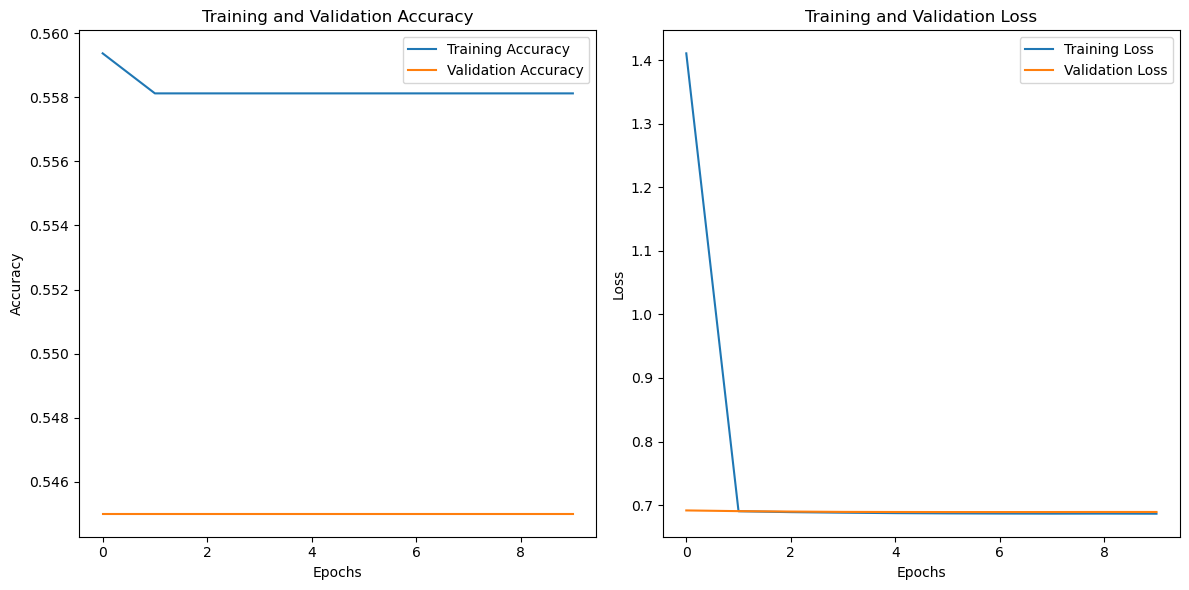

In [4]:
# Plot Training and Validation Accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Mean Absolute Error
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_mae, label='Training MAE', marker='o')
plt.plot(range(1, epochs + 1), val_mae, label='Validation MAE', marker='o')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model.save("resnet_land_price_model.h5")
print("Model training complete. The model has been saved as 'resnet_land_price_model.h5'.")